In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
%tensorflow_version 1.x

In [ ]:

import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
from tensorflow.keras import utils as np_utils
import tensorflow.keras.backend as K
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
# from keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from art.estimators.classification import KerasClassifier
tf.compat.v1.disable_eager_execution()

In [ ]:
import matplotlib.pyplot as plt
def show_image( img ):
    plt.imshow( img)
    plt.axis( 'off' )
    plt.show( )

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_test = to_categorical(y_test, 10)
y_train = to_categorical(y_train, 10)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255
# print(y_train.shape)
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 10)
assert y_test.shape == (10000, 10)

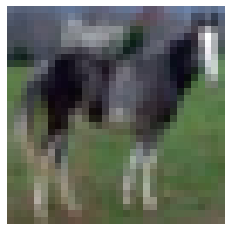

In [ ]:
show_image(x_train[37])

In [ ]:
print(y_train[37])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
import tensorflow_hub as hub

model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
# model2 = hub.load(model_url,signature="image_classification")

In [ ]:
from tensorflow.keras import Sequential
model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
model_main = hub.KerasLayer(model_url, input_shape=(32, 32, 3))
victim_model = tf.keras.Sequential([
        model_main,
        tf.keras.layers.Activation('softmax')
])

victim_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
victim_model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 10)                7796426   
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [ ]:
victim_classifier = KerasClassifier(model=victim_model, clip_values=(0., 1.))
predictions = victim_classifier.predict(x_test) 
dependent_maxvalue = np.argmax(y_test, axis=1)
predict_maxvalue = np.argmax(predictions, axis=1)

# calculates the accuracy of the predictions
begin_example_accuracy = np.sum(predict_maxvalue == dependent_maxvalue) / len(y_test) 
acc_rate = begin_example_accuracy * 100

print("Accuracy for classifier on original test set: {}%\n".format(acc_rate))

Accuracy for classifier on original test set: 94.52000000000001%



In [ ]:
tf.__version__

'1.15.2'

In [ ]:
def extract_n_percent(n):
   
    num_imgs = x_train.shape[ 0 ]
    num_poisoned_images = n
    print( 'Percentage of access to train images', num_poisoned_images*100 / num_imgs )
    idx = np.arange( num_imgs, dtype=np.int )
    np.random.shuffle( idx )
    candidate_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )
    target_labels=np.copy( y_train[ idx[ :num_poisoned_images ] ] )
    # target_labels=[lb for i in range(num_poisoned_images)]
    # target_labels=np.array(target_labels)
    return candidate_images,target_labels

In [ ]:
#tf.compat.v1.disable_eager_execution()

In [ ]:
from art.estimators.classification import KerasClassifier
wrapper_exc = KerasClassifier(model = victim_model, use_logits=False)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model2.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model2.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
#model2.add(Dropout(0.5))
model.add(Dense(10))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


#Create the classifier
thieved_classifier = KerasClassifier(model=model, clip_values=(0, 1.0))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

#CopyCat with 5% =2500

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(2500)

Percentage of access to train images 5.0


In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 2ms/sample - loss: 8.1633 - acc: 0.1300
Epoch 2/5
100/100 [==============================] - 0s 732us/sample - loss: 8.6198 - acc: 0.1300
Epoch 3/5
100/100 [==============================] - 0s 691us/sample - loss: 6.9403 - acc: 0.1200
Epoch 4/5
100/100 [==============================] - 0s 691us/sample - loss: 8.7038 - acc: 0.1100
Epoch 5/5
100/100 [==============================] - 0s 688us/sample - loss: 8.7038 - acc: 0.1100


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 81us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

increase the querries 100

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=100,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


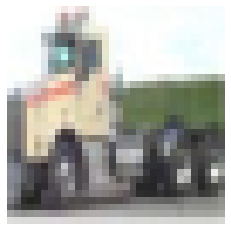

9

In [ ]:
show_image(x_exc[2500])
np.argmax(y_exc[2500])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 773us/sample - loss: 8.8650 - acc: 0.1000
Epoch 2/5
100/100 [==============================] - 0s 680us/sample - loss: 8.8650 - acc: 0.1000
Epoch 3/5
100/100 [==============================] - 0s 717us/sample - loss: 8.8650 - acc: 0.1000
Epoch 4/5
100/100 [==============================] - 0s 704us/sample - loss: 8.8650 - acc: 0.1000
Epoch 5/5
100/100 [==============================] - 0s 698us/sample - loss: 8.8650 - acc: 0.1000


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 72us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

increase the querries 1000

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=1000,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


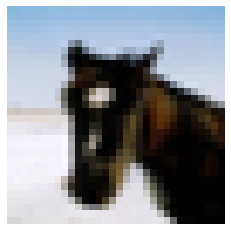

7

In [ ]:
show_image(x_exc[2500])
np.argmax(y_exc[2500])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 737us/sample - loss: 8.3814 - acc: 0.1200
Epoch 2/5
100/100 [==============================] - 0s 740us/sample - loss: 8.3814 - acc: 0.1200
Epoch 3/5
100/100 [==============================] - 0s 712us/sample - loss: 8.3814 - acc: 0.1200
Epoch 4/5
100/100 [==============================] - 0s 720us/sample - loss: 8.3814 - acc: 0.1200
Epoch 5/5
100/100 [==============================] - 0s 705us/sample - loss: 8.3814 - acc: 0.1200


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 71us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

10 % data access = 5000

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


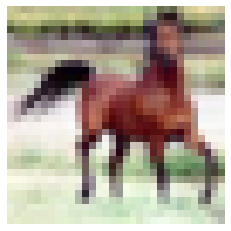

7

In [ ]:
show_image(x_exc[2500])
np.argmax(y_exc[2500])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 745us/sample - loss: 9.3485 - acc: 0.1200
Epoch 2/5
100/100 [==============================] - 0s 736us/sample - loss: 9.3485 - acc: 0.1200
Epoch 3/5
100/100 [==============================] - 0s 701us/sample - loss: 9.3485 - acc: 0.1200
Epoch 4/5
100/100 [==============================] - 0s 707us/sample - loss: 9.3485 - acc: 0.1200
Epoch 5/5
100/100 [==============================] - 0s 720us/sample - loss: 9.3485 - acc: 0.1200


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 70us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

increase the querries 100

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=100,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


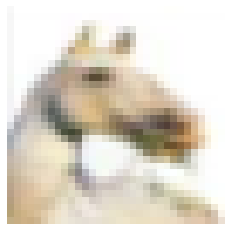

7

In [ ]:
show_image(x_exc[2500])
np.argmax(y_exc[2500])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 716us/sample - loss: 7.7367 - acc: 0.0800
Epoch 2/5
100/100 [==============================] - 0s 718us/sample - loss: 7.7367 - acc: 0.0800
Epoch 3/5
100/100 [==============================] - 0s 707us/sample - loss: 7.7367 - acc: 0.0800
Epoch 4/5
100/100 [==============================] - 0s 731us/sample - loss: 7.7367 - acc: 0.0800
Epoch 5/5
100/100 [==============================] - 0s 717us/sample - loss: 7.7367 - acc: 0.0800


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 72us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

increase the querries 1000

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=1000,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


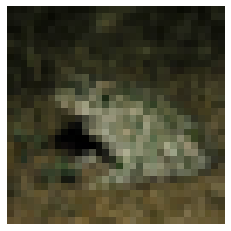

6

In [ ]:
show_image(x_exc[2500])
np.argmax(y_exc[2500])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 709us/sample - loss: 8.5426 - acc: 0.1300
Epoch 2/5
100/100 [==============================] - 0s 681us/sample - loss: 8.5426 - acc: 0.1300
Epoch 3/5
100/100 [==============================] - 0s 697us/sample - loss: 8.5426 - acc: 0.1300
Epoch 4/5
100/100 [==============================] - 0s 703us/sample - loss: 8.5426 - acc: 0.1300
Epoch 5/5
100/100 [==============================] - 0s 720us/sample - loss: 8.5426 - acc: 0.1300


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 73us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

30% = 15000 data access

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(15000)

Percentage of access to train images 30.0


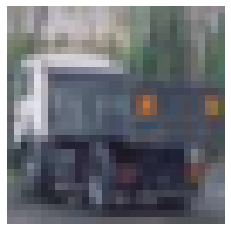

9

In [ ]:
show_image(x_exc[2500])
np.argmax(y_exc[2500])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 786us/sample - loss: 8.3814 - acc: 0.1100
Epoch 2/5
100/100 [==============================] - 0s 689us/sample - loss: 8.3814 - acc: 0.1100
Epoch 3/5
100/100 [==============================] - 0s 749us/sample - loss: 8.3814 - acc: 0.1100
Epoch 4/5
100/100 [==============================] - 0s 746us/sample - loss: 8.3814 - acc: 0.1100
Epoch 5/5
100/100 [==============================] - 0s 745us/sample - loss: 8.3814 - acc: 0.1100


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 73us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

increase the querries 100

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=100,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


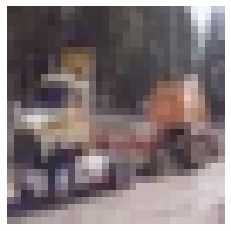

9

In [ ]:
show_image(x_exc[2500])
np.argmax(y_exc[2500])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 741us/sample - loss: 7.7367 - acc: 0.0600
Epoch 2/5
100/100 [==============================] - 0s 702us/sample - loss: 7.7367 - acc: 0.0600
Epoch 3/5
100/100 [==============================] - 0s 757us/sample - loss: 7.7367 - acc: 0.0600
Epoch 4/5
100/100 [==============================] - 0s 739us/sample - loss: 7.7367 - acc: 0.0600
Epoch 5/5
100/100 [==============================] - 0s 707us/sample - loss: 7.7367 - acc: 0.0600


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 72us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

increase the querries 1000

In [ ]:
from art.attacks.extraction import CopycatCNN
exc_cc = CopycatCNN(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=1000,
                        nb_epochs=5,
                        nb_stolen=100)

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


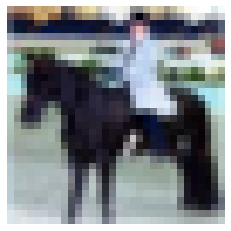

7

In [ ]:
show_image(x_exc[2500])
np.argmax(y_exc[2500])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 724us/sample - loss: 8.5426 - acc: 0.1600
Epoch 2/5
100/100 [==============================] - 0s 765us/sample - loss: 8.5426 - acc: 0.1600
Epoch 3/5
100/100 [==============================] - 0s 741us/sample - loss: 8.5426 - acc: 0.1600
Epoch 4/5
100/100 [==============================] - 0s 719us/sample - loss: 8.5426 - acc: 0.1600
Epoch 5/5
100/100 [==============================] - 0s 760us/sample - loss: 8.5426 - acc: 0.1600


In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 71us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

#Knockoff Nets

5% data access

In [ ]:
from art.attacks.extraction import KnockoffNets
exc_cc = KnockoffNets(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100,reward="all")

In [ ]:
x_exc,y_exc = extract_n_percent(2500)

Percentage of access to train images 5.0


In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 73us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

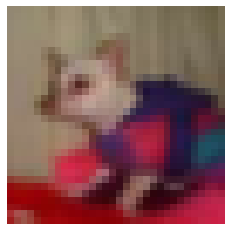

5

In [ ]:
show_image(x_exc[250])
np.argmax(y_exc[250])

# query = 100

In [ ]:
from art.attacks.extraction import KnockoffNets
exc_cc = KnockoffNets(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=100,
                        nb_epochs=5,
                        nb_stolen=100,reward="all")

In [ ]:
x_exc,y_exc = extract_n_percent(2500)

Percentage of access to train images 5.0


In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 71us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

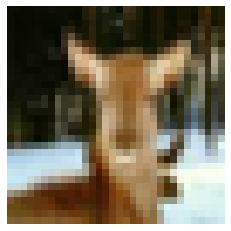

4

In [ ]:
show_image(x_exc[250])
np.argmax(y_exc[250])

# query = 1000

In [ ]:
from art.attacks.extraction import KnockoffNets
exc_cc = KnockoffNets(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=1000,
                        nb_epochs=5,
                        nb_stolen=100,reward="all")

In [ ]:
x_exc,y_exc = extract_n_percent(2500)

Percentage of access to train images 5.0


In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 73us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

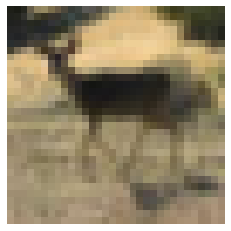

4

In [ ]:
show_image(x_exc[250])
np.argmax(y_exc[250])

10% data access

In [ ]:
from art.attacks.extraction import KnockoffNets
exc_cc = KnockoffNets(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100,reward="all")

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


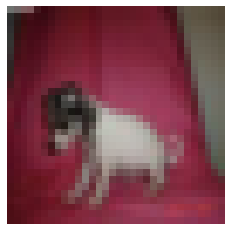

5

In [ ]:
show_image(x_exc[1000])
np.argmax(y_exc[1000])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 73us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

100 querry

In [ ]:
from art.attacks.extraction import KnockoffNets
exc_cc = KnockoffNets(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=100,
                        nb_epochs=5,
                        nb_stolen=100,reward="all")

In [ ]:
x_exc,y_exc = extract_n_percent(5000)

Percentage of access to train images 10.0


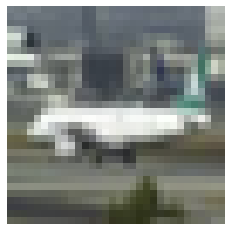

0

In [ ]:
show_image(x_exc[1000])
np.argmax(y_exc[1000])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 74us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]

30% access

In [ ]:
from art.attacks.extraction import KnockoffNets
exc_cc = KnockoffNets(classifier = wrapper_exc, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=1000,reward="all")

In [ ]:
x_exc,y_exc = extract_n_percent(15000)

Percentage of access to train images 30.0


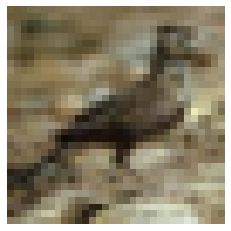

2

In [ ]:
show_image(x_exc[1000])
np.argmax(y_exc[1000])

In [ ]:
stolen_cls = exc_cc.extract(x_exc,y_exc,thieved_classifier=thieved_classifier)

In [ ]:
stolen_cls._model.evaluate(x_test,y_test)

10000/10000 [==============================] - 1s 73us/sample - loss: 8.0590 - acc: 0.1000


[8.059047782897949, 0.1]